In [40]:
import pandas as pd
from networkx.readwrite import json_graph
import json
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from graph_tool.all import *
import graph_tool as gt
pd.set_option("display.max_columns",500)

In [30]:
courses=pd.read_csv("Course_Info.csv")

In [31]:
enrollments=pd.read_csv("DataJamDays.csv",encoding="latin9")

In [51]:
courses.loc[courses.CourseCode=="CS-433"]

,AcademicYear,CourseCode,CourseTitleFR,CourseTitleEN,ProfessorSCIPERs,AssistantSCIPERs,StudyPlansFR,StudyPlansEN,Summary_FR,Summary_EN,KeyWords_FR,KeyWords_EN,Content_FR,Content_EN,ImportantConcepts_FR,ImportantConcepts_EN,MandatoryPrerequirements_FR,MandatoryPrerequirements_EN,IndicativePrerequirements_FR,IndicativePrerequirements_EN,PreparesFor_FR,PreparesFor_EN,Handouts_FR,Handouts_EN,Bibliography_FR,Bibliography_EN,TeachingMethod_FR,TeachingMethod_EN,EvaluationMethod_FR,EvaluationMethod_EN,ExpectedWork_FR,ExpectedWork_EN,Other_FR,Other_EN,ProjectManagement,WorkInSociety,PersonalEffectiveness,TrainingAchievements,WorkInGroupsAndOrgs,CommunicateInformation
578,2016-2017,CS-433,Pattern classification and machine learning,NaN,276449;124369,244595,SC - Master EPFL 2016;IN - Master 2016;HD - Ma...,EDIC 2016-17;EDNE 2016-17,Classification de modèle occupe un rôle centra...,Pattern classification occupies a central role...,NaN,NaN,&lt;p&gt;&lt;strong&gt;I. \tClassification et ...,&lt;ol&gt;\n&lt;li&gt;Basic regression and cla...,NaN,&lt;ul&gt;\n&lt;li&gt;Programming in Matlab (b...,NaN,&lt;ul&gt;\n&lt;li&gt;Analysis I<comma/> II<co...,&lt;p&gt;Probabilité et statistique I<comma/> ...,&lt;ul&gt;\n&lt;li&gt;Introduction to differen...,NaN,NaN,NaN,&lt;p&gt;The course comes with partially-fille...,&lt;p&gt;Polycopiés : C. Bishop : Pattern Re...,&lt;p&gt;The following books will be used for ...,&lt;p&gt;Ex cathedra<comma/> exercices en sall...,&lt;ul&gt;\n&lt;li&gt;Lectures&lt;/li&gt;\n&lt...,&lt;p&gt;Examen écrit &amp;amp; miniprojet&lt;...,&lt;ul&gt;\n&lt;li&gt;Continuous control&lt;/l...,NaN,&lt;ul&gt;\n&lt;li&gt;Students MUST attend lec...,NaN,NaN,NaN,NaN,Auto-évaluer son niveau de compétence acquise ...,[Généraliser] them to new problems\n[Choisir o...,NaN,NaN


In [38]:
js_graph["nodes"][561]

{'id': 561, 'label': 'CIVIL-402'}

In [5]:
with open("graph.json") as f:
    js_graph = json.load(f)
js_graph["links"]=js_graph["edges"]
G=json_graph.node_link_graph(js_graph)

In [16]:
gtG = nx2gt(G)

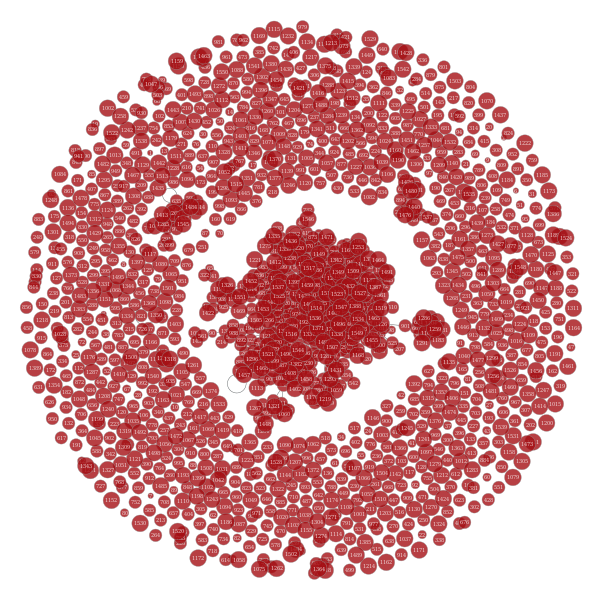

In [28]:
draw(gtG)

In [27]:
def draw(G): 
    plt.figure(figsize=(50,50))
    text=G.vertex_index
    plt.switch_backend('cairo')  # the only supported backend
    plt.figure(figsize=(20,20))
    pos = gt.draw.sfdp_layout(G)
    gt.draw.graph_draw(G, vertex_text=text, pos=pos,vertex_font_size=5)


In [15]:
def get_prop_type(value, key=None):
    """
    Performs typing and value conversion for the graph_tool PropertyMap class.
    If a key is provided, it also ensures the key is in a format that can be
    used with the PropertyMap. Returns a tuple, (type name, value, key)
    """
    if isinstance(key, bytes):
        # Encode the key as ASCII
        key = key.encode('ascii', errors='replace')

    # Deal with the value
    if isinstance(value, bool):
        tname = 'bool'

    elif isinstance(value, int):
        tname = 'float'
        value = float(value)

    elif isinstance(value, float):
        tname = 'float'

    elif isinstance(value, str):
        tname = 'string'
        value = value.encode('ascii', errors='replace')

    elif isinstance(value, dict):
        tname = 'object'

    else:
        tname = 'string'
        value = str(value)

    return tname, value, key


def nx2gt(nxG):
    """
    Converts a networkx graph to a graph-tool graph.
    """
    # Phase 0: Create a directed or undirected graph-tool Graph
    gtG = gt.Graph(directed=nxG.is_directed())

    # Add the Graph properties as "internal properties"
    for key, value in nxG.graph.items():
        # Convert the value and key into a type for graph-tool
        tname, value, key = get_prop_type(value, key)

        prop = gtG.new_graph_property(tname) # Create the PropertyMap
        gtG.graph_properties[key] = prop     # Set the PropertyMap
        gtG.graph_properties[key] = value    # Set the actual value

    # Phase 1: Add the vertex and edge property maps
    # Go through all nodes and edges and add seen properties
    # Add the node properties first
    nprops = set() # cache keys to only add properties once
    for node, data in nxG.nodes(data=True):

        # Go through all the properties if not seen and add them.
        for key, val in data.items():
            if key in nprops: continue # Skip properties already added

            # Convert the value and key into a type for graph-tool
            tname, _, key  = get_prop_type(val, key)

            prop = gtG.new_vertex_property(tname) # Create the PropertyMap
            gtG.vertex_properties[key] = prop     # Set the PropertyMap

            # Add the key to the already seen properties
            nprops.add(key)

    # Also add the node id: in NetworkX a node can be any hashable type, but
    # in graph-tool node are defined as indices. So we capture any strings
    # in a special PropertyMap called 'id' -- modify as needed!
    gtG.vertex_properties['id'] = gtG.new_vertex_property('string')

    # Add the edge properties second
    eprops = set() # cache keys to only add properties once
    for src, dst, data in nxG.edges(data=True):

        # Go through all the edge properties if not seen and add them.
        for key, val in data.items():
            if key in eprops: continue # Skip properties already added

            # Convert the value and key into a type for graph-tool
            tname, _, key = get_prop_type(val, key)

            prop = gtG.new_edge_property(tname) # Create the PropertyMap
            gtG.edge_properties[key] = prop     # Set the PropertyMap

            # Add the key to the already seen properties
            eprops.add(key)

    # Phase 2: Actually add all the nodes and vertices with their properties
    # Add the nodes
    vertices = {} # vertex mapping for tracking edges later
    for node, data in nxG.nodes(data=True):

        # Create the vertex and annotate for our edges later
        v = gtG.add_vertex()
        vertices[node] = v

        # Set the vertex properties, not forgetting the id property
        data['id'] = str(node)
        for key, value in data.items():
            gtG.vp[key][v] = value # vp is short for vertex_properties

    # Add the edges
    for src, dst, data in nxG.edges(data=True):

        # Look up the vertex structs from our vertices mapping and add edge.
        e = gtG.add_edge(vertices[src], vertices[dst])

        # Add the edge properties
        for key, value in data.items():
            gtG.ep[key][e] = value # ep is short for edge_properties

    # Done, finally!
    return gtG
